In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
sns.set()


In [8]:
dick = pd.read_pickle('country_data.pkl')
world_df = pd.read_pickle('global_data.pkl')

swe = dick['Sweden']
swe

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-01-24,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2020-01-25,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-26,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-27,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-28,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-03-31,4435,1.101043,407.0,180,1.232877,34.0,4.058625,24.638889,1.119736
2020-04-01,4947,1.115445,512.0,239,1.327778,59.0,4.831211,20.698745,1.190357
2020-04-02,5568,1.125531,621.0,308,1.288703,69.0,5.531609,18.077922,1.144974
2020-04-03,6131,1.101114,563.0,358,1.162338,50.0,5.839178,17.125698,1.055602


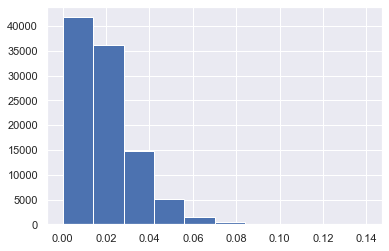

In [9]:
M_mu_s = pm.rbeta(alpha=2,beta=100,size=100000)
_ = plt.hist(M_mu_s)

1.0464187082393095

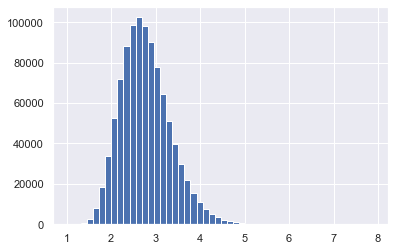

In [10]:
F_mu_s = pm.rlognormal(1,1/0.2**2, size=1000000)
_ = plt.hist(F_mu_s,bins=50)

F_mu_s.min()

++++++++ US ++++++++++

            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-03-08        518  1.288557  116.0        21     1.235294       4.0   
2020-03-10        959  1.644940  376.0        28     1.272727       6.0   
2020-03-11       1281  1.335766  322.0        36     1.285714       8.0   
2020-03-12       1663  1.298205  382.0        40     1.111111       4.0   
2020-03-13       2179  1.310283  516.0        47     1.175000       7.0   

            pct_dead  conf_over_dead  dead_conf_ratio  
2020-03-08  4.054054       24.666667         0.958665  
2020-03-10  2.919708       34.250000         0.773723  
2020-03-11  2.810304       35.583333         0.962529  
2020-03-12  2.405292       41.575000         0.855883  
2020-03-13  2.156953       46.361702         0.896753  

 [-----------------100%-----------------] 1000000 of 1000000 complete in 1439.9 sec[0.00541051 0.00827203] [2.69919019 4.13189241]

        M_alpha_post    M_beta_post      F_mu_post   F_s

 [-----------------100%-----------------] 1000000 of 1000000 complete in 1350.3 sec[0.01381973 0.02539181] [2.74994172 4.51825557]

        M_alpha_post    M_beta_post      F_mu_post   F_sigma_post  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean       18.137066     670.132711       1.470134       0.202188   
std        10.224252     233.246655       0.258805       0.057986   
min         1.002416       4.635486       1.100001       0.100000   
25%        10.804980     505.612799       1.241597       0.152041   
50%        16.502504     710.657751       1.428645       0.203286   
75%        23.703020     867.169755       1.681251       0.253038   
max       101.724999     999.999740       2.000000       0.299997   

              M_post         F_post  gen_dead_post  
count  250000.000000  250000.000000  250000.000000  
mean        0.024738       4.392936      16.433740  
std         0.009338       1.727353       0.150513  
min         0.005449       1.21808

 [-----------------100%-----------------] 1000000 of 1000000 complete in 1347.5 sec[0.00437032 0.00730669] [2.81630298 4.54585267]

        M_alpha_post    M_beta_post      F_mu_post   F_sigma_post  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        5.568636     673.552058       1.477733       0.200693   
std         3.055662     229.176033       0.253169       0.058022   
min         1.000254       2.919304       1.100001       0.100008   
25%         3.271558     510.407608       1.256682       0.150354   
50%         5.020764     710.133290       1.444214       0.201082   
75%         7.258556     868.603980       1.679934       0.251154   
max        30.115635     999.995703       1.999950       0.299998   

              M_post         F_post  gen_dead_post  
count  250000.000000  250000.000000  250000.000000  
mean        0.006682       4.429362       4.483585  
std         0.002305       1.522929       0.341196  
min         0.001528       0.98989

 [-----------------100%-----------------] 1000000 of 1000000 complete in 1342.8 sec[0.00848425 0.01416247] [2.8056453  4.53906717]

        M_alpha_post    M_beta_post      F_mu_post   F_sigma_post  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        9.834255     671.154268       1.480237       0.200379   
std         5.307604     231.160696       0.253273       0.057836   
min         1.000359       1.646313       1.100005       0.100002   
25%         5.886791     507.903711       1.259041       0.150349   
50%         9.028473     710.425007       1.447826       0.200417   
75%        12.880506     866.493053       1.682781       0.250641   
max        58.181155     999.974099       1.999995       0.300000   

              M_post         F_post  gen_dead_post  
count  250000.000000  250000.000000  250000.000000  
mean        0.012958       4.434004       5.630645  
std         0.004377       1.501493       0.448208  
min         0.003485       1.08812

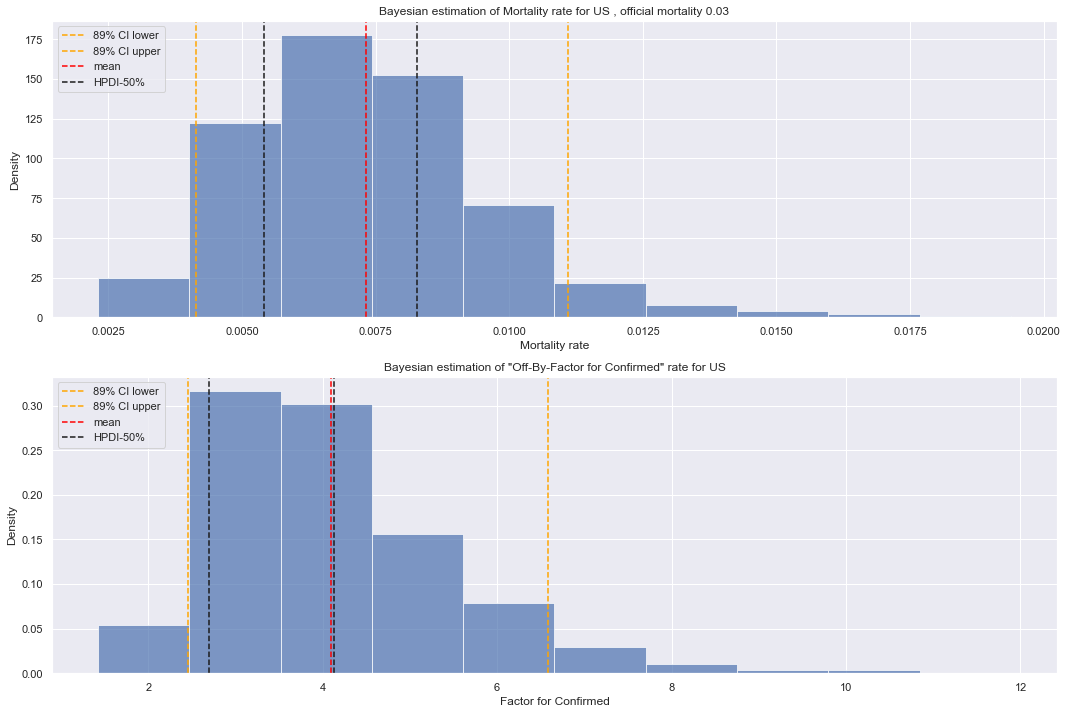

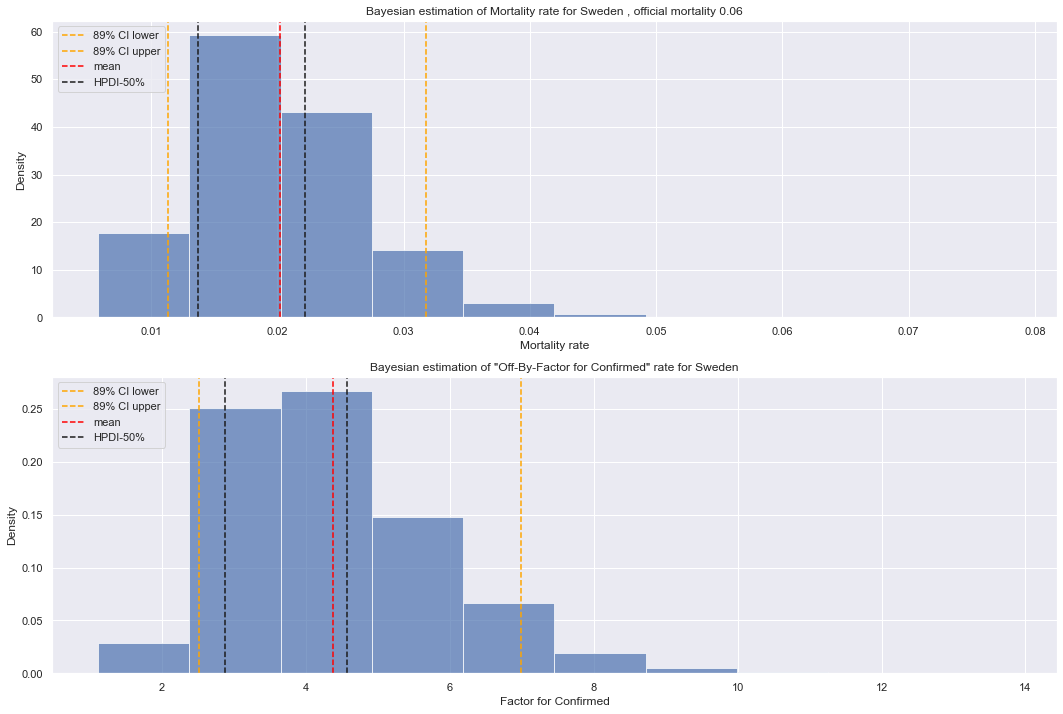

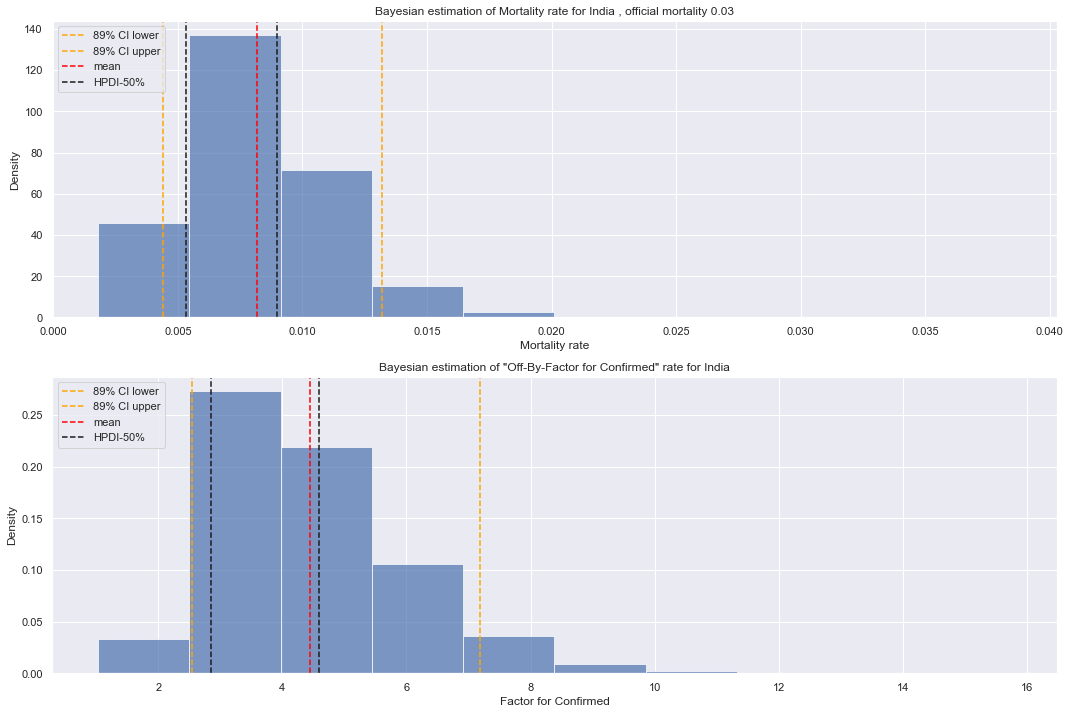

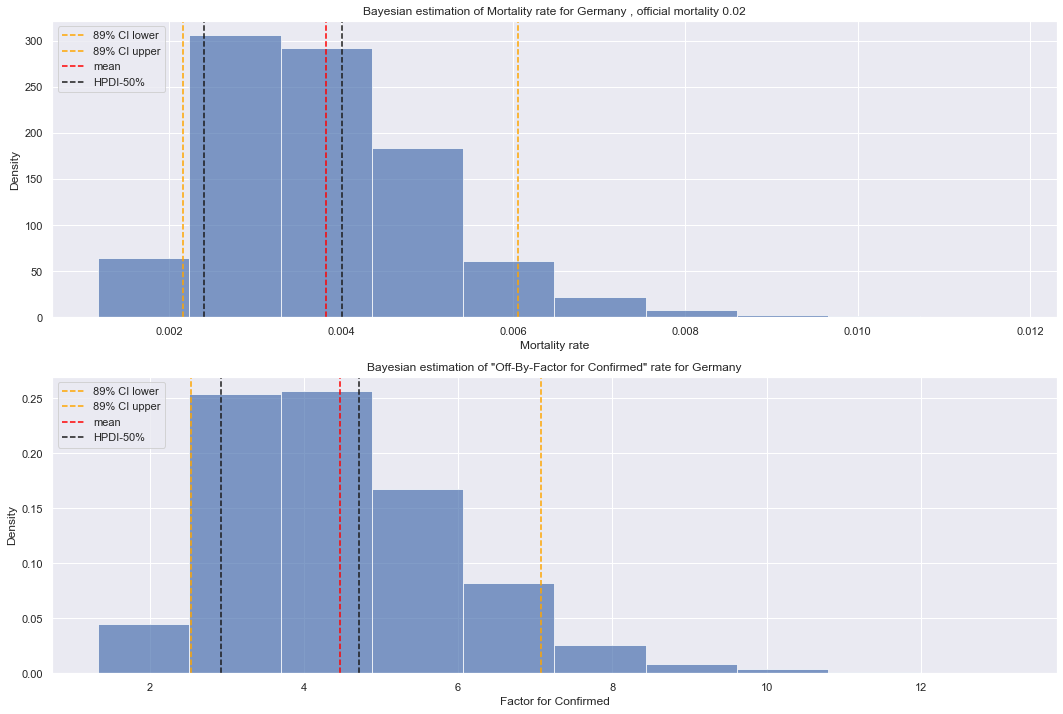

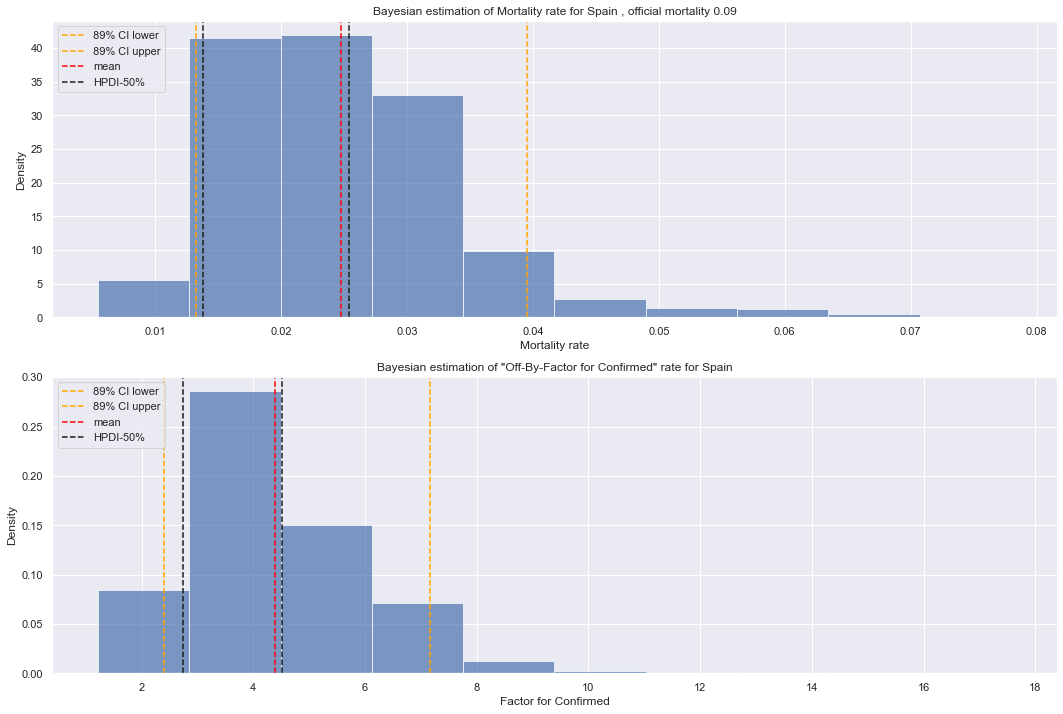

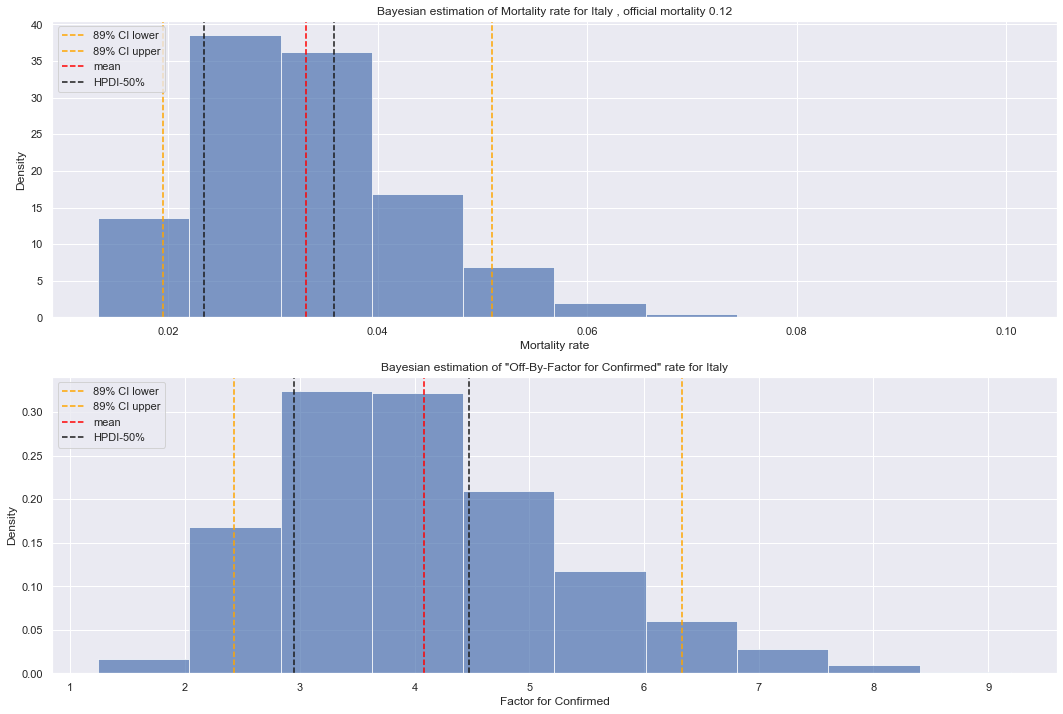

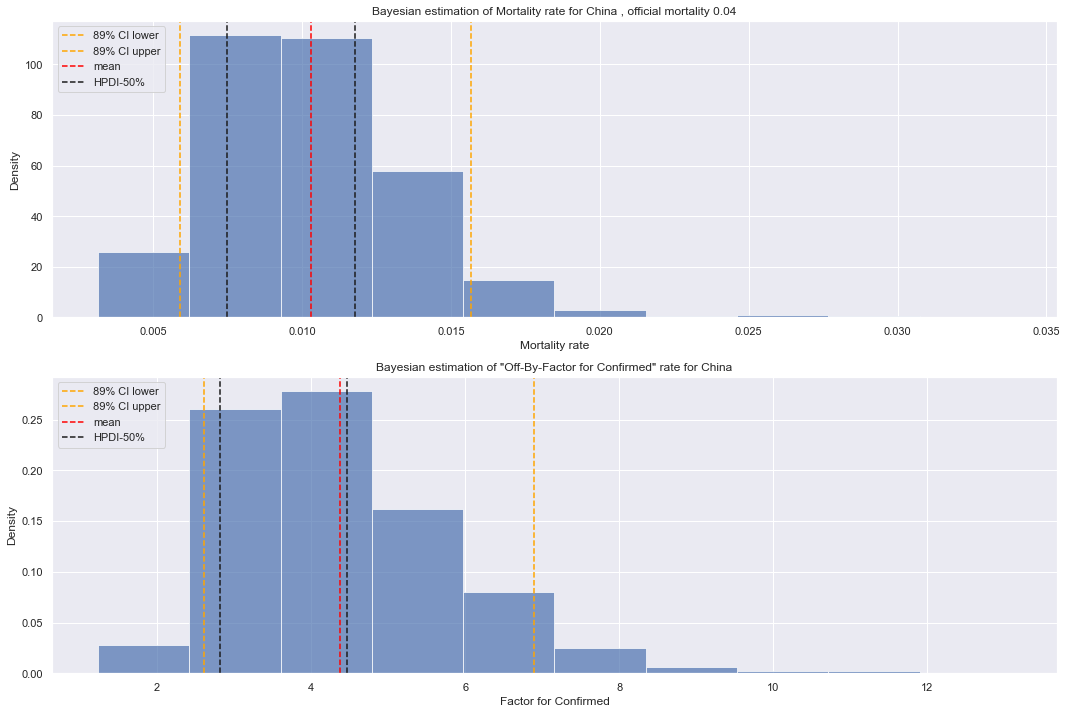

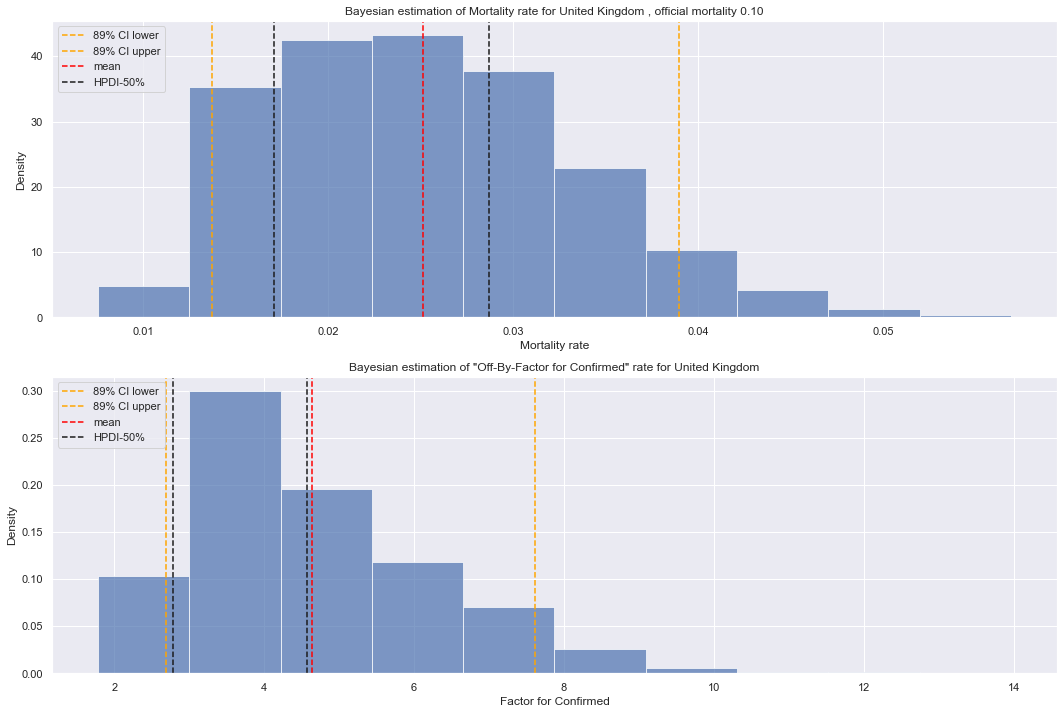

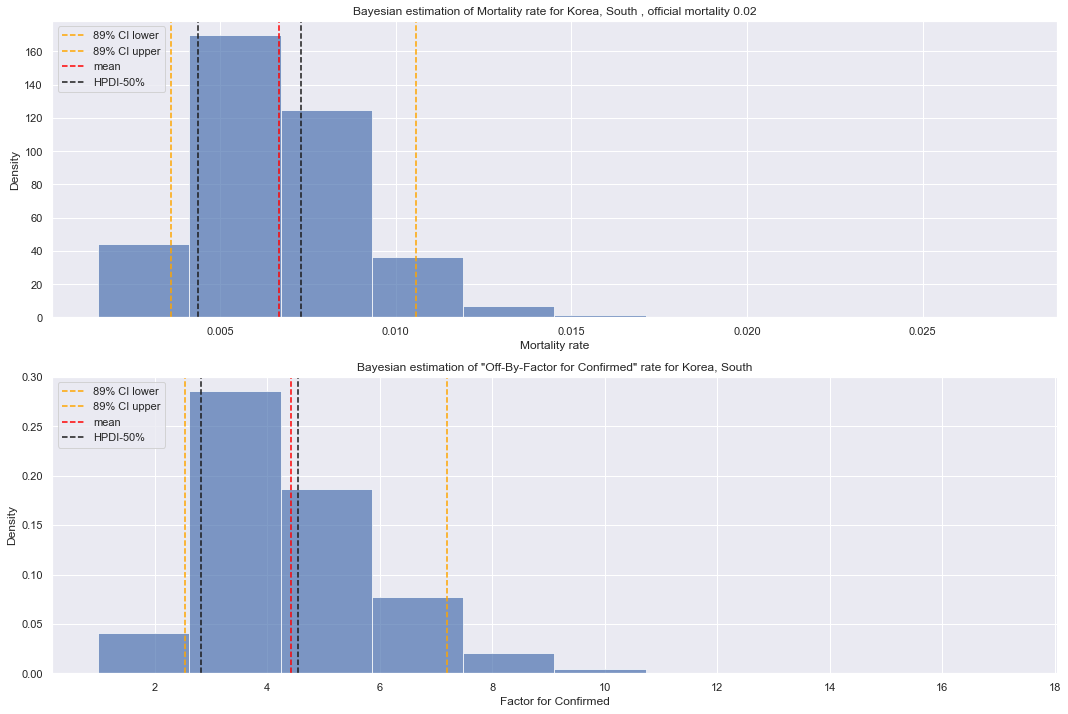

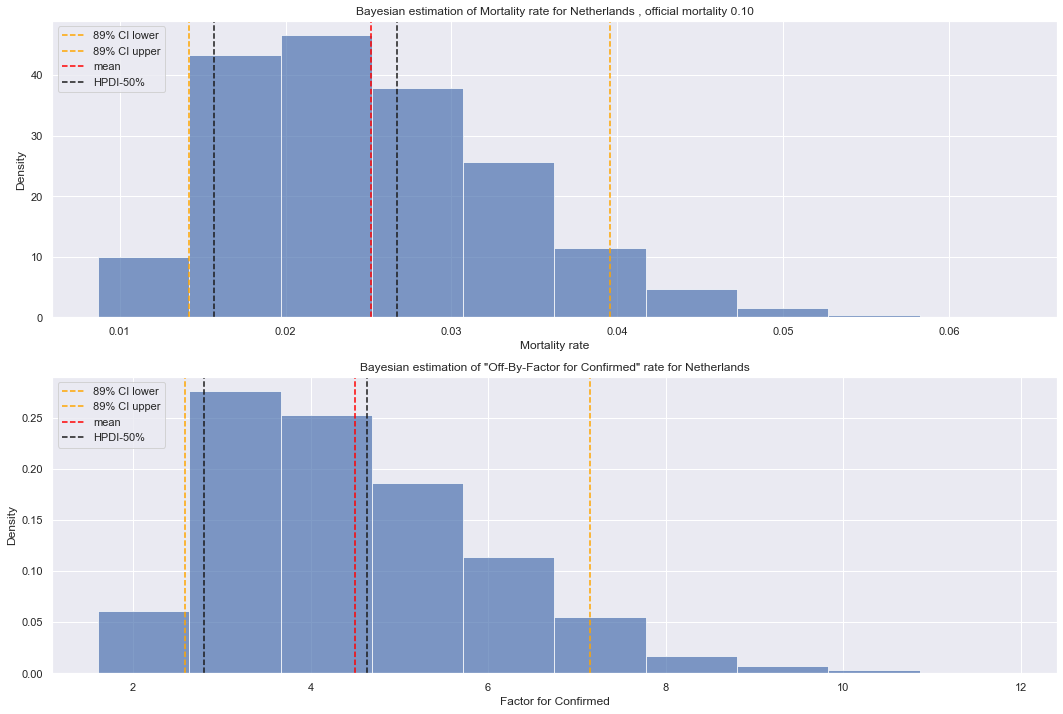

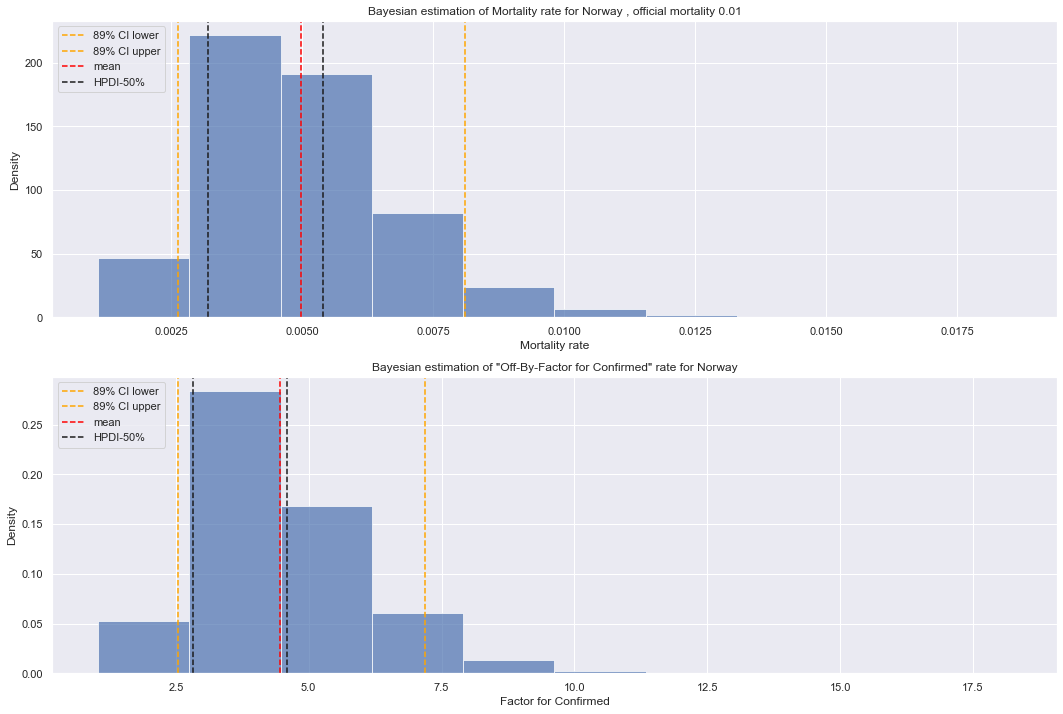

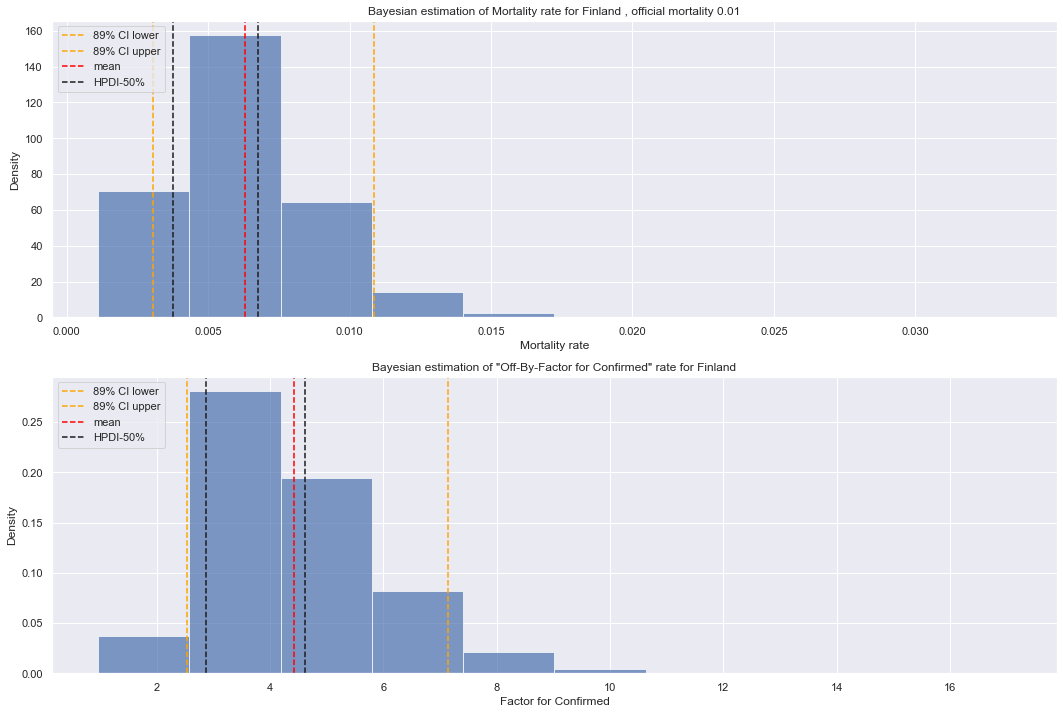

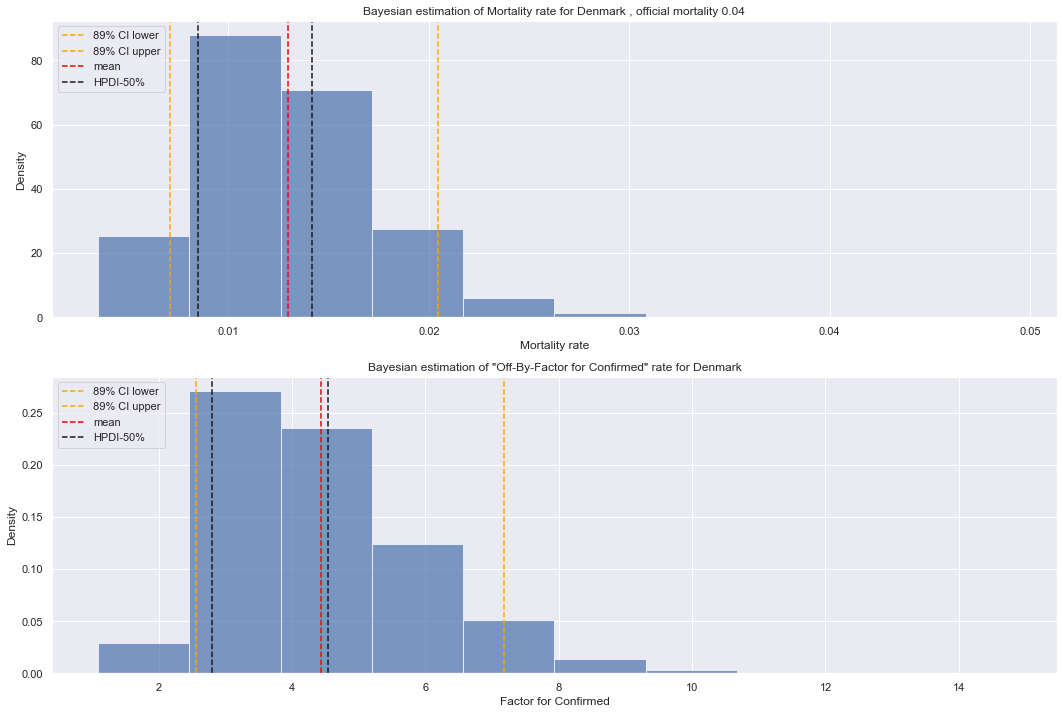

In [11]:


def process_country(country,C,D):
    df = dick[country]
    
    mask = df['confirmed'] > 500
    df = df[mask]
    mask = df['deceased'] > 5
    df = df[mask]
    mask = df['dead_inc'] > 1 # or it crashes when doing inc  & dead_inc
    df = df[mask]
    
    print ('++++++++ {} ++++++++++'.format(country))
    print ()
    print (df.tail())
    print()
    
    if df.size < 1 :
        print ('Not enough data - DataFrame empty! ')
    else:
        confirmed_mean = df['confirmed'].mean()
        confirmed_std = df['confirmed'].std()
        dead_mean = df['deceased'].mean()
        dead_std = df['deceased'].std()

        #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
        #dead_s = (df['deceased'] - dead_mean) / dead_std

        confirmed_s = df[C]
        dead_s = df[D]

        #plt.plot(confirmed_s,dead_s,'x--')

        #M_mu = pm.Uniform('M_mu',lower=0.1,upper=1)

        F_mu = pm.Uniform('F_mu',lower=1.1,upper=2)
        F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.3)

        M_alpha = pm.Uniform('M_alpha',lower=1,upper=1000)
        M_beta = pm.Uniform ('M_beta',lower=1,upper=1000)


        M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
        F = pm.Lognormal('F',mu=F_mu, tau=1 / F_sigma ** 2) #0.6 0.2


        @pm.deterministic()
        def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
            return confirmed_s * F * M

        obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)

        model = pm.Model([M_alpha,M_beta,F_mu,F_sigma,M,F,gen_dead,obs])
        map_ = pm.MAP(model)
        
        try:
            map_.fit()
        except:
            print ('couldnt fit {}'.format(country))

        mcmc = pm.MCMC(model)
        mcmc.sample(1000000,500000,2)

        M_alpha_post = mcmc.trace('M_alpha')[:]
        M_beta_post = mcmc.trace('M_beta')[:]
        F_mu_post = mcmc.trace('F_mu')[:]
        F_sigma_post = mcmc.trace('F_sigma')[:]
        M_post = mcmc.trace('M')[:]
        F_post = mcmc.trace('F')[:]
        gen_dead_post = mcmc.trace('gen_dead')[:,0]

        result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                                   'M_beta_post' : M_beta_post,
                                   'F_mu_post' : F_mu_post,
                                   'F_sigma_post' : F_sigma_post,
                                   'M_post' : M_post,
                                   'F_post' : F_post,
                              'gen_dead_post' : gen_dead_post})
        

        return result
    return None

def plot(country_name,result,official_mortality):
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    hpdi_M = pm.utils.hpd(result.M_post, alpha=0.50)
    hpdi_F = pm.utils.hpd(result.F_post,alpha=0.50)
    
    print (hpdi_M,hpdi_F)
    
    plt.figure(figsize=(18,12))
    plt.subplot(211)
    plt.title('Bayesian estimation of Mortality rate for {} , official mortality {:.2f}'.format(
        country_name,official_mortality / 100))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper')
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean')
    plt.axvline(hpdi_M[0],color='k',label='HPDI-50%',ls='dashed')
    plt.axvline(hpdi_M[1],color='k',ls='dashed')
    
    hist = plt.hist(result.M_post,density=True,bins=10,alpha=0.7,color='b')
    #plt.fill_between(x=hpdi_M,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')
    plt.legend(loc='upper left')


    plt.subplot(212)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(country_name))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper')
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean')
    plt.axvline(hpdi_F[0],color='k',label='HPDI-50%',ls='dashed')
    plt.axvline(hpdi_F[1],color='k',ls='dashed')
    
    hist = plt.hist(result.F_post,density=True,bins=10,alpha=0.7,color='b')
    #plt.fill_between(x=hpdi_F,y1=0,y2=max(hist[0]),color='r',alpha=0.7,label='HPDI-50%')

    plt.legend(loc='upper left')

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}_.jpg'.format(country_name),format='jpg')

countries = ['US','Sweden','India','Germany','Spain','Italy','China',
             'United Kingdom','Korea, South','Netherlands','Norway','Finland','Denmark']

for c in countries:
    
    result = process_country(c,'inc','dead_inc')
    if not (result is None) :
        official_mortality = dick[c].iloc[-1,6]
        plot(c,result,official_mortality)
        print ()
        print (result.describe())
       

 [-----------------100%-----------------] 1000000 of 1000000 complete in 1368.6 sec

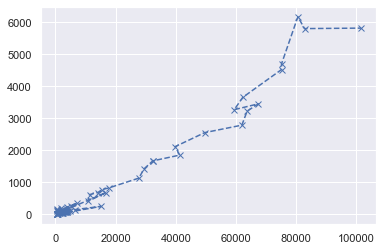

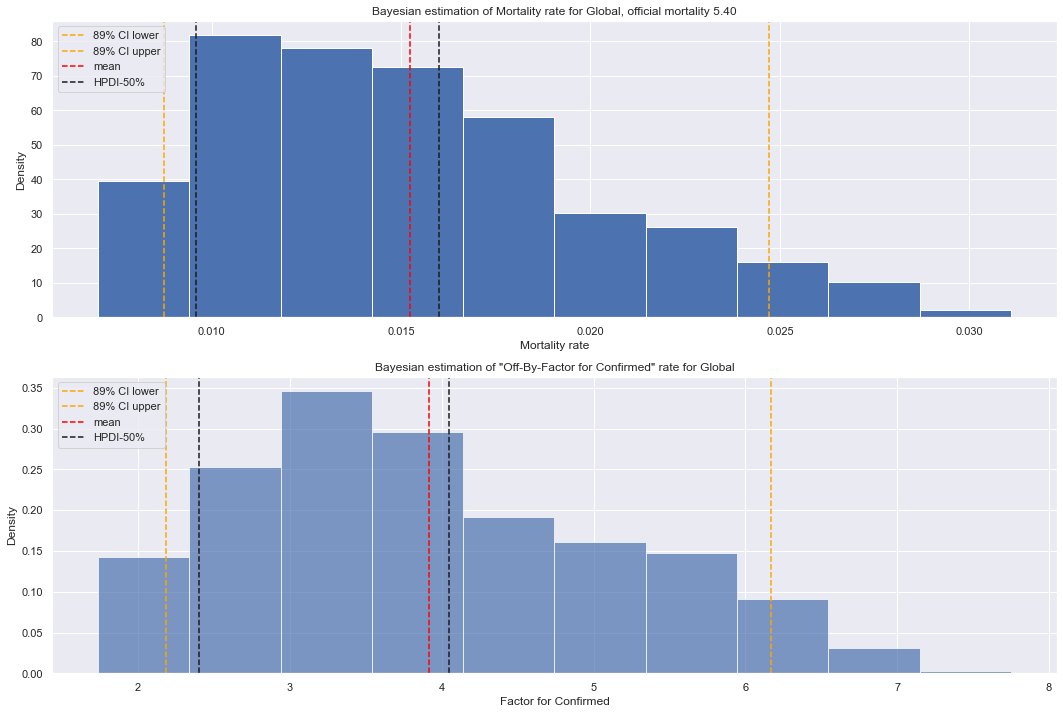

In [12]:
def process_world(df,C,D):
    
    mask = df['confirmed'] > 1000
    df = df[mask]
    mask = df['dead'] > 5
    df = df[mask]
    
    confirmed_mean = df['confirmed'].mean()
    confirmed_std = df['confirmed'].std()
    dead_mean = df['dead'].mean()
    dead_std = df['dead'].std()
    
    #confirmed_s = (df['confirmed'] - confirmed_mean) / confirmed_std
    #dead_s = (df['deceased'] - dead_mean) / dead_std
    
    confirmed_s = df[C]
    dead_s = df[D]
    
    plt.plot(confirmed_s,dead_s,'x--')
    
    #F_mu = pm.Uniform('F_mu',lower=1,upper=1.2)
    #F_sigma = pm.Uniform('F_sigma',lower=0.19,upper=0.21)
    
    F_mu = pm.Uniform('F_mu',lower=1.1,upper=2)
    F_sigma = pm.Uniform('F_sigma',lower=0.1,upper=0.3)
    
    M_alpha = pm.Uniform('M_alpha',lower=1,upper=1000)
    M_beta = pm.Uniform ('M_beta',lower=1,upper=1000)
    
    
    M = pm.Beta('M',alpha=M_alpha,beta=M_beta)
    F = pm.Lognormal('F',mu=F_mu, tau=1 / F_sigma ** 2) #0.6 0.2
    
    
    @pm.deterministic()
    def gen_dead(confirmed_s=confirmed_s,F=F,M=M):
        return confirmed_s * F * M
    
    obs = pm.Poisson('obs',mu=gen_dead,observed=True,value=dead_s)
    
    model = pm.Model([M_alpha,M_beta,F_mu,F_sigma,M,F,gen_dead,obs])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(1000000,500000,2)
    
    M_alpha_post = mcmc.trace('M_alpha')[:]
    M_beta_post = mcmc.trace('M_beta')[:]
    F_mu_post = mcmc.trace('F_mu')[:]
    F_sigma_post = mcmc.trace('F_sigma')[:]
    M_post = mcmc.trace('M')[:]
    F_post = mcmc.trace('F')[:]
    gen_dead_post = mcmc.trace('gen_dead')[:,0]
    
    result = pd.DataFrame({'M_alpha_post' : M_alpha_post,
                          'M_beta_post' : M_beta_post,
                          'F_mu_post' : F_mu_post,
                          'F_sigma_post' : F_sigma_post,
                          'M_post' : M_post,
                          'F_post' : F_post,
                          'gen_dead_post' : gen_dead_post})
    
    return result

def plot_world(result,title,official_mortality):
    
    M_low,M_high = np.percentile(result.M_post,[5.5,94.5])
    F_low,F_high = np.percentile(result.F_post,[5.5,94.5])
    
    hpdi_M = pm.utils.hpd(result.M_post, alpha=0.50)
    hpdi_F = pm.utils.hpd(result.F_post,alpha=0.50)
    
    
    plt.figure(figsize=(18,12))
    plt.subplot(211)
    plt.title('Bayesian estimation of Mortality rate for {}, official mortality {:.2f}'.format(title,official_mortality))
    plt.xlabel('Mortality rate')
    plt.ylabel('Density')
    plt.axvline(M_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(M_high,color='orange',ls='dashed',label='89% CI upper')
    plt.axvline(result.M_post.mean(),color='red',ls='dashed',label='mean')
    
    plt.axvline(hpdi_M[0],color='k',label='HPDI-50%',ls='dashed')
    plt.axvline(hpdi_M[1],color='k',ls='dashed')
    
    hist = plt.hist(result.M_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper left')
    plt.hist(result.M_post,density=True,bins=10)

    plt.subplot(212)
    plt.title('Bayesian estimation of "Off-By-Factor for Confirmed" rate for {}'.format(title))
    plt.xlabel('Factor for Confirmed')
    plt.ylabel('Density')
    plt.axvline(F_low,color='orange',ls='dashed',label='89% CI lower')
    plt.axvline(F_high,color='orange',ls='dashed',label='89% CI upper')
    plt.axvline(result.F_post.mean(),color='red',ls='dashed',label='mean')
    
    plt.axvline(hpdi_F[0],color='k',label='HPDI-50%',ls='dashed')
    plt.axvline(hpdi_F[1],color='k',ls='dashed')
    
    hist = plt.hist(result.F_post,density=True,bins=10,alpha=0.7,color='b')

    plt.legend(loc='upper left')

    plt.savefig('Bayesian_estimate_mortality_and_factor_{}.jpg'.format(title),format='jpg')

world_df = pd.read_pickle('global_data.pkl')

result_world = process_world(world_df,'inc','dead_inc')
official_mortality = world_df.iloc[-1,6]
plot_world(result_world,'Global',official_mortality)
